In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import json

In [2]:
def load_arrays_from_file(filename):
    try:
        with open(filename, 'r') as file:
            loaded_data = json.load(file)
            
        converted_data = {}
        for key_str, value in loaded_data.items():
            stripped_key = key_str.strip("()")
            a, b = map(float, stripped_key.split(","))
            converted_data[(a, b)] = np.array(value[1:])
        
        return converted_data
    
    except FileNotFoundError:
        return {}
    except json.JSONDecodeError:
        return {}

In [3]:
data = load_arrays_from_file('Series/s1000/series.json')

In [4]:
data_ddos = load_arrays_from_file('Series/s1000/series_ddos.json')
data_dpi = load_arrays_from_file('Series/s1000/series_dpi.json')
data_spoof = load_arrays_from_file('Series/s1000/series_spoof.json')

In [6]:
params = (0.05, 200)
data_series = data[params]
data_test_series = data_series[len(data_series) // 2:]
ddos_series = data_ddos[params]
ddos_test_series = ddos_series[len(ddos_series) // 2:]
dpi_series = data_dpi[params]
dpi_test_series = dpi_series[len(dpi_series) // 2:]
spoof_series = data_spoof[params]
spoof_test_series = spoof_series[len(spoof_series) // 2:]

train_series = data_series[0: len(data_series) // 2]
test_series = data_series[len(data_series) // 2:]

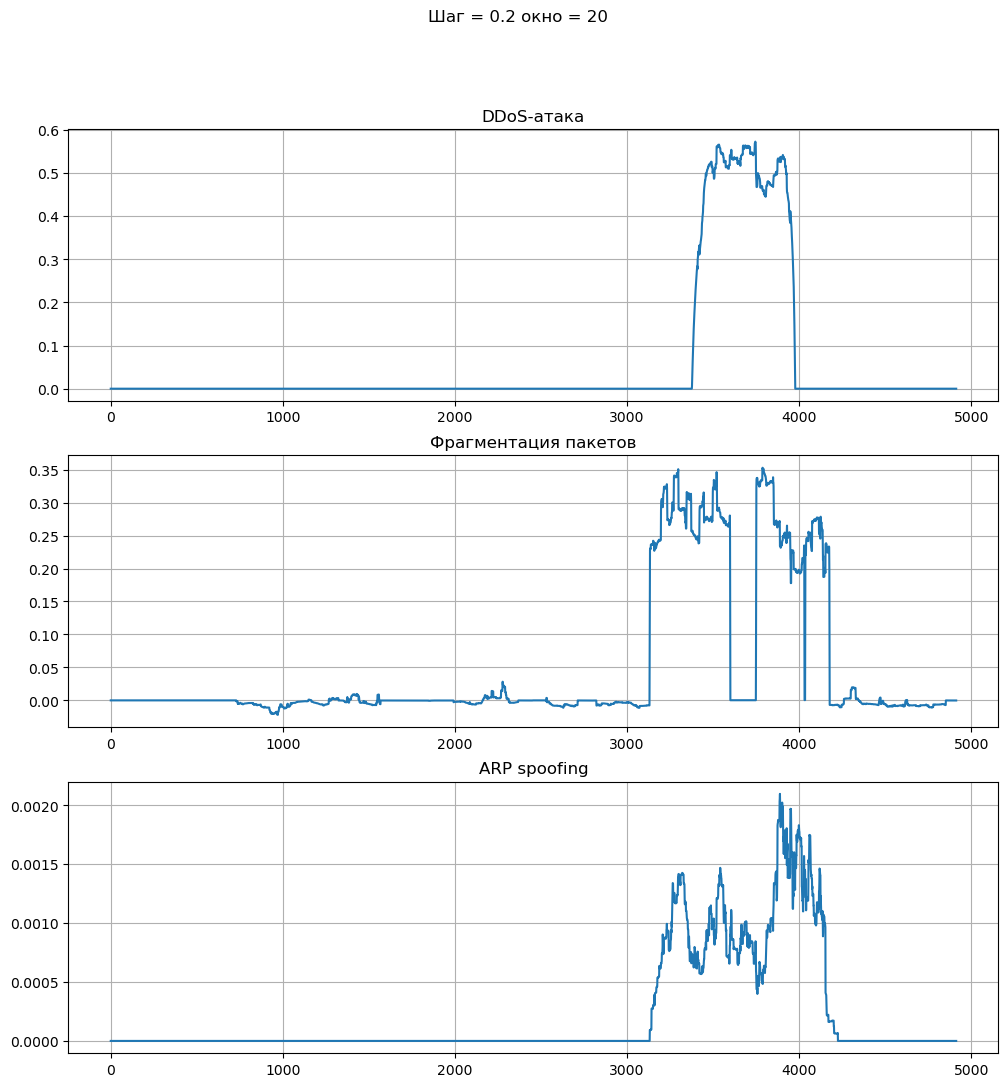

In [9]:
t_params = (0.2, 20)
data_series = data[t_params]
ddos_series = data_ddos[t_params]
dpi_series = data_dpi[t_params]
spoof_series = data_spoof[t_params]
fig, axes = plt.subplots(3, 1, figsize=(12, 12))
fig.suptitle("Шаг = 0.2 окно = 20", fontsize=12)
ax = axes[0]
ax.plot(-data_series + ddos_series)
ax.set_title('DDoS-атака')
ax.grid(True)
ax = axes[1]
ax.plot(-data_series + dpi_series)
ax.set_title('Фрагментация пакетов')
ax.grid(True)
ax = axes[2]
ax.plot( - data_series + spoof_series)
ax.set_title('ARP spoofing')
ax.grid(True)
plt.savefig('j3.png')
plt.show()

In [10]:
data_dpi[(0.01, 200)].shape

(62226,)

In [209]:
train_series = data_series[0: len(series) // 2]
test_series = data_series[len(series) // 2:]

In [177]:
ddos_series = data_ddos[(0.5, 100)]
ddos_test_series = ddos_series[len(ddos_series) // 2:]

In [158]:
dpi_series = data_dpi[(0.01, 100)]
dpi_test_series = dpi_series[len(dpi_series) // 2:]

In [197]:
spoof_series = data_spoof[(0.01, 100)]
spoof_test_series = spoof_series[len(spoof_series) // 2:]

In [45]:
params = (0.1, 100)
data_series = data[params]
data_test_series = data_series[len(data_series) // 2:]
ddos_series = data_ddos[params]
ddos_test_series = ddos_series[len(ddos_series) // 2:]
dpi_series = data_dpi[params]
dpi_test_series = dpi_series[len(dpi_series) // 2:]
spoof_series = data_spoof[params]
spoof_test_series = spoof_series[len(spoof_series) // 2:]

train_series = data_series[0: len(data_series) // 2]
test_series = data_series[len(data_series) // 2:]

In [46]:
import torch.nn.functional as F
def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        x = data[i:i+seq_len]
        y = data[i+seq_len]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_len = 20
X, y = create_sequences(train_series, seq_len)

X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=20, dropout = 0.05, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional = True)
        self.l = nn.Linear(hidden_size * 2, 1)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.l(x)
        return x


In [47]:
device = torch.device('cuda')

In [48]:
model = LSTMModel(num_layers = 2, dropout = 0, hidden_size = 20).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [49]:
epochs = 50
batch_size = 32
dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
model.train()
for epoch in range(epochs):
    m_loss = 0
    for xb, yb in dataloader:
        pred = model(xb.to(device))
        loss = criterion(pred, yb.to(device))
        m_loss += loss.cpu().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {m_loss / len(dataloader)}")

Epoch 1/50, Loss: 0.0037420531316456618
Epoch 2/50, Loss: 0.00048615370033289196
Epoch 3/50, Loss: 1.2346641497629207e-05
Epoch 4/50, Loss: 9.53627827371406e-06
Epoch 5/50, Loss: 8.533517992681539e-06
Epoch 6/50, Loss: 8.42048645743887e-06
Epoch 7/50, Loss: 8.25852227315238e-06
Epoch 8/50, Loss: 7.400521112366221e-06
Epoch 9/50, Loss: 7.088522601783609e-06
Epoch 10/50, Loss: 7.834149456265038e-06
Epoch 11/50, Loss: 7.005146670735485e-06
Epoch 12/50, Loss: 6.897395147031915e-06
Epoch 13/50, Loss: 6.530904165913398e-06
Epoch 14/50, Loss: 7.339501257863645e-06
Epoch 15/50, Loss: 7.647176000658007e-06
Epoch 16/50, Loss: 5.6741594600673295e-06
Epoch 17/50, Loss: 6.24703064033838e-06
Epoch 18/50, Loss: 7.254716381410731e-06
Epoch 19/50, Loss: 5.874749788858935e-06
Epoch 20/50, Loss: 5.31616209809016e-06
Epoch 21/50, Loss: 5.5921142179116146e-06
Epoch 22/50, Loss: 5.880889791587407e-06
Epoch 23/50, Loss: 5.5418414994790055e-06
Epoch 24/50, Loss: 5.430566203390441e-06
Epoch 25/50, Loss: 6.9731

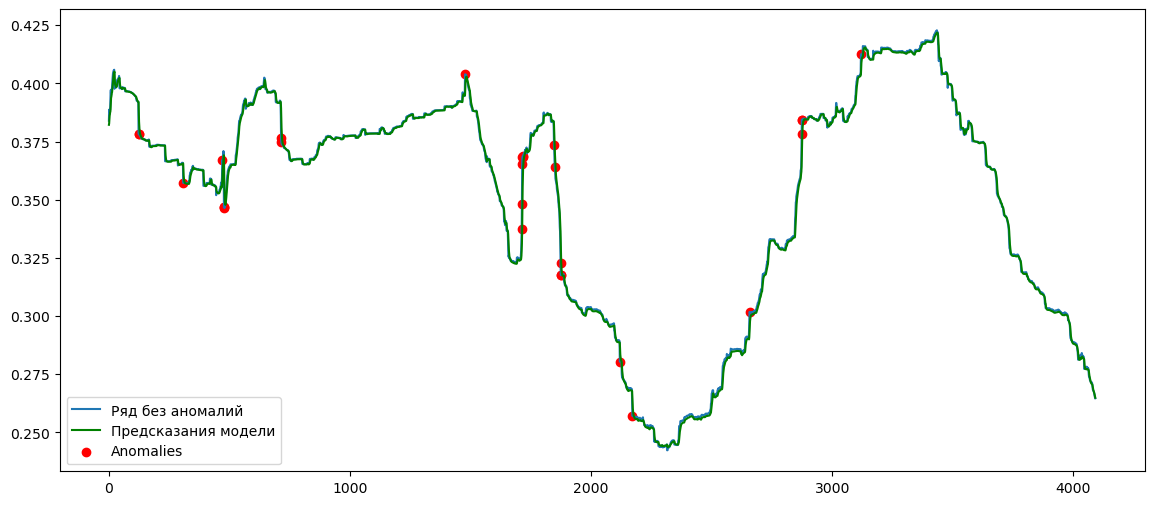

In [57]:
model.eval()
model.cpu()
with torch.no_grad():
    preds = model(X_tensor).squeeze().numpy()

errors = np.abs(preds - y)
threshold = np.mean(errors) + 5 * np.std(errors)
anomalies = np.where(errors > threshold)[0]

plt.figure(figsize=(14, 6))
plt.plot(y, label='Ряд без аномалий')
plt.plot(preds, label='Предсказания модели', color = 'green')
plt.scatter(anomalies, y[anomalies], color='red', label='Anomalies')
plt.legend()
#plt.savefig('j41.png')
plt.show()

In [36]:
test_series = data_test_series

In [55]:
test_series = ddos_test_series

In [53]:
test_series = dpi_test_series

In [675]:
test_series = spoof_test_series

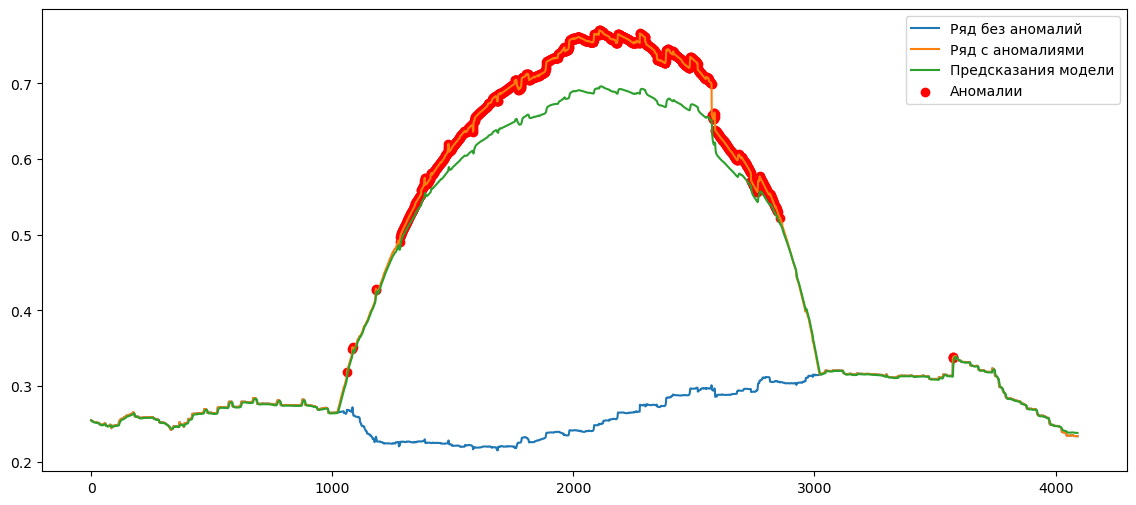

In [58]:
model.eval()
X_test, y_test = create_sequences(test_series, seq_len)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)
with torch.no_grad():
    preds = model(X_test_tensor).squeeze().numpy()

errors = np.abs(preds - y_test)
anomalies = np.where(errors > threshold)[0]

plt.figure(figsize=(14, 6))
plt.plot(data_test_series[20:], label='Ряд без аномалий')
plt.plot(y_test, label='Ряд с аномалиями')
plt.plot(preds, label='Предсказания модели')
plt.scatter(anomalies, y_test_tensor[anomalies], color='red', label='Аномалии')
plt.legend()
#plt.savefig('j414.png')
#plt.title("LSTM Anomaly Detection (PyTorch)")
plt.show()